In [892]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import inspect

import models.ac_stark as stark
import models.rydberg_calcs as ryd
import plotters.plot_ac_stark as pac

from scipy.constants import c as C_c, h as C_h, k as C_k, e as C_e
from scipy.constants import physical_constants, pi, epsilon_0, hbar

In [893]:
def E(P, w):
    # Intensity/beam (W/m^2)
    I = 2.0 * P / (np.pi * w**2)
    # Electric field (V/m)
    E = np.sqrt(2.0 * I / (epsilon_0 * C_c))
    return E

In [986]:
from arc import Cesium as Cs
from arc import Rubidium as Rb
cs = Cs()
# cs = Rb()

def Omega(state1, state2, P, w, q):
    HFS = [np.shape(state1)[0] == 5, np.shape(state2)[0] == 5]
    
    n1, l1, j1 = (state1[0], state1[1], state1[2])
    n2, l2, j2 = (state2[0], state2[1], state2[2])
    rme = cs.getReducedMatrixElementJ(n1, l1, j1, n2, l2, j2)
    # print(rme)
    rme *= C_e * physical_constants["Bohr radius"][0]
    
    if HFS == [True, True]:
        # print("Both HFS")
        f1, mf1 = (state1[3], state1[4])
        f2, mf2 = (state2[3], state2[4])
        ame = (cs.getSphericalDipoleMatrixElement(f1, mf1, f2, mf2, q)
               * cs._reducedMatrixElementFJ(j1, f1, j2, f2))
        # print(ame)

    #NOTE: These two situations (where only one state considers HFS) should
    # only be used when we are seeing how much some HF state couples up to 
    # ANY of the J states. getSphericalMatrixElementHFStoFS automatically sets
    # the mI value of the J state so that we are coupled.
    elif HFS == [True, False]:
        # print("State 1 HFS")
        f1, mf1 = (state1[3], state1[4])
        mj2 = state2[3]
        ame = cs.getSphericalMatrixElementHFStoFS(j1, f1, mf1, j2, mj2, q)
        # print(ame)

    elif HFS == [False, True]:
        # print("State 2 HFS")
        mj1 = state1[3]
        f2, mf2 = (state2[3], state2[4])
        ame = cs.getSphericalMatrixElementHFStoFS(j2, f2, mf2, j1, mj1, q)
        # print(ame)
    
    elif HFS == [False, False]:
        # print("Neither HFS")
        mj1 = state1[3]
        mj2 = state2[3]
        ame = cs.getSphericalDipoleMatrixElement(j1, mj1, j2, mj2, q)
    
    Omega = E(P, w) * rme * ame / hbar
    # returns in units of rad/s so energy is hbar times this.
    return Omega

def get_HFS(state):
    n, l, j, f = (state[0], state[1], state[2], state[3])
    try:
        [A, B] = cs.getHFSCoefficients(n, l, j)
        Ehfs = cs.getHFSEnergyShift(j, f, A, B)
    except:
        Ehfs = 0
        # print(f"no HFS data for state {state}")
    return Ehfs

def w_0(state1, state2):
    #Returns in units of 1/s
    HFS = [np.shape(state1)[0] == 5, np.shape(state2)[0] == 5]
    
    n1, l1, j1 = (state1[0], state1[1], state1[2])
    n2, l2, j2 = (state2[0], state2[1], state2[2])
    
    E_1 = cs.getEnergy(n1, l1, j1)*C_e/C_h
    E_2 = cs.getEnergy(n2, l2, j2)*C_e/C_h

    if HFS[0]:
        Ehfs = get_HFS(state1)
        E_1 += Ehfs
    if HFS[1]: 
        Ehfs = get_HFS(state2)
        E_1 += Ehfs

    w_0 = E_2 - E_1
    return w_0
    
def Delta(state1, state2, wavelength, perturb_sign = False, Bloch_Siegert = False):
    w0 = w_0(state1, state2)

    freq = C_c / wavelength
    # print(freq)
    
    if perturb_sign:
        sign_factor = np.sign(w0)
    else: 
        sign_factor = 1

    #See Steck Eq. 7.455
    if Bloch_Siegert:
        delta = 2*np.pi*(freq**2 - (w0)**2) / (2 * np.abs(w0))
    else:
        delta = 2*np.pi*(freq - np.abs(w0))

    # returns in units of rad/s so energy is hbar times this
    return delta*sign_factor

def generate_basis_gs(gs, wavelength, q):
    #HF groundstates
    n1, l1, j1, f1, mf1 = (gs[0], gs[1], gs[2], gs[3], gs[4])

    #Heuristic ranges that should give enough of a buffer. Pretty conservative
    if wavelength > 895e-9:
        n_max = 6
    elif wavelength < 450e-9:
        n_max = 15
    else:
        n_max = 10

    # l = 1

    basis = []
    for n in range(6, n_max+1):
        # for j in [1/2, 3/2]:
        #     I = cs.I
        #     f_min = max([f1-1, int(np.abs(j-I))])
        #     f_max = np.min([f1+2, int(j+I)])
        #     for f in range(f_min, f_max+1):
        #         q_sign = np.sign(w_0(gs, [n,l,j,f,f]))
        #         mf = mf1 + q * q_sign
        #         if not(f == f1 and q == 0 and mf == 0):
        #             if np.abs(mf) <= f:
        #                 state = [n, l, j, f, mf]
        #                 basis.append(state)
        for l in [l1-1, l1+1]:  
            for j in [l+1/2, l-1/2]:
                if np.abs(j-j1)< 1.1:
                    I = cs.I
                    f_min = max([f1-1, int(np.abs(j-I))])
                    f_max = np.min([f1+2, int(j+I)])
                    for f in range(f_min, f_max+1):
                        q_sign = np.sign(w_0(gs, [n,l,j,f,f]))
                        mf = int(mf1 + q * q_sign)
                        if not(f == f1 and q == 0 and mf == 0):
                            if np.abs(mf) <= f and np.abs(f-f1)< 1.1:
                                state = [n, l, j, f, mf]
                                basis.append(state)

    return basis

def generate_basis_rydberg(rydstate, wavelength, q, mw_dn = 5):
    #Low l rydberg states. This code really only gives accurate results for microwave 
    #wavelengths (which couple only Rydberg-Rydberg states) 
    #or optical (which couple Rydberg-Low n)
    n1, l1, j1, f1, mf1 = (rydstate[0], rydstate[1], rydstate[2], rydstate[3], rydstate[4])

    #Heuristic ranges that should give enough of a buffer. Pretty conservative
    n_min_optical = 6
    if wavelength < 450e-9:
        n_max_optical = 8
    elif wavelength < 900e-9:
        n_max_optical = 10
    elif wavelength < 2000e-9:
        n_max_optical = 12

    n_max_optical = 8

    n_max_mw = int(n1 + mw_dn)
    n_min_mw = int(n1 - mw_dn)
    n_range = range(n_min_mw, n_max_mw+1)
    if wavelength < 10000e-9:
        n_range_optical = range(n_min_optical, n_max_optical+1)
        n_range = np.concatenate([n_range_optical, n_range])
        # n_range = n_range_optical
    basis = []
    for n in n_range:
        for l in [l1-1, l1+1]:  
            for j in [l+1/2, l-1/2]:
                if np.abs(j-j1)< 1.1:
                    I = cs.I
                    f_min = max([f1-1, int(np.abs(j-I))])
                    f_max = np.min([f1+2, int(j+I)])
                    for f in range(f_min, f_max+1):
                        q_sign = np.sign(w_0(rydstate, [n,l,j,f,f]))
                        mf = int(mf1 + q * q_sign)
                        if not(f == f1 and q == 0 and mf == 0):
                            if np.abs(mf) <= f and np.abs(f-f1)< 1.1:
                                state = [n, l, j, f, mf]
                                basis.append(state)

    return basis
    
def ac_stark(state, wavelength, P, w, q, largest_contrib = 0):
    if state[0]<7:
        basis = generate_basis_gs(state, wavelength, q)
        B_S = False
    if state[0]>15:
        basis = generate_basis_rydberg(state, wavelength, q, mw_dn = 3)
        B_S = True
    
    U = 0
    contributions = []
    for state2 in basis:
        delta = Delta(state, state2, wavelength, perturb_sign = True, Bloch_Siegert = B_S)
        omega = Omega(state, state2, P, w, q)
        if omega == 0:
            omega = Omega(state2, state, P, w, q)
        #Both Omega and Delta return in units of rad/s, so U is also in rad/s
        U_i = omega**2 / (4*delta)
        if largest_contrib > 0:
            contributions.append([state2, delta, omega, U_i])
        # print(state2, 
        #       np.round(w_0(state, state2)*1e-9,3),
        #       np.round(delta*1e-9/(2*np.pi),3), 
        #       np.round(omega*1e-9/(2*np.pi),3), 
        #       np.round(U_i*1e-6/(2*np.pi),3))
        U += U_i

    if largest_contrib > 0:
        # print(contributions)
        contrib_transpose = [list(i) for i in zip(*contributions)]
        contrib_inds = np.argsort(np.abs(contrib_transpose[-1]))[-largest_contrib:]
        # print(np.abs(contrib_transpose[-1]))
        biggest_contribs = [contributions[i] for i in contrib_inds]
        # print(biggest_contribs)

    #returns in rad/s
    if largest_contrib > 0:
        return U, biggest_contribs
    else:
        return U

## Startk Shifts

### Single Wavelength Stark Shifts

In [918]:
state = [6,0,0.5,4,4]
wavelength = 455.655e-9
P = 0.01
w = 25e-6
q = 1
# basis = generate_basis_gs(state, wavelength, q)
# print(basis)

# Omegas = []
# for s in basis:
#     Omegas.append(Omega(state, s, P, w, q) * 1e-6 / (2*np.pi))
# print(Omegas)

U, contrib = ac_stark(state, wavelength, P, w, q, largest_contrib = 1)
print(U * 1e-6 / (2*np.pi))
print(contrib[0][2]* 1e-6 / (2*np.pi))

IndexError: list index out of range

In [937]:
state1 = [61,2,3/2,3,3]
state2 = [62,1,1/2,3,3]

test_state = [61, 3, 2.5, 4, 2]
freq = 298139.450*1e9
wavelength = C_c / freq
# wavelength = 1064e-9
P = 30e-3
w = 3.4e-6
q = 0
print(Omega(test_state, state1, P, w, q))
print(Omega(state1, test_state, P, w, q))

U1 = ac_stark(state1, wavelength, P, w, q)
U1 = U1  * 1e-6 / (2*np.pi)
print("hi")
U2 = ac_stark(state2, wavelength, P, w, q) * 1e-6 / (2*np.pi)

print(U1, U2)
print(U1-U2)
# print([contrib[i][0] for i in range(contrib_num)])

-0.0
0.0
[np.int64(6), 1, 1.5, 3, 3] -295816.235 -2332.338 0.047 -0.0
[np.int64(6), 1, 1.5, 4, 3] -295816.274 -2332.298 0.026 -0.0
[np.int64(6), 1, 0.5, 3, 3] -298139.978 0.528 0.144 9.804
[np.int64(6), 3, 2.5, 3, 3] -90896.49 -443498.755 0.233 -0.0
[np.int64(6), 3, 2.5, 4, 3] -90896.49 -443498.755 -0.173 -0.0
[np.int64(7), 1, 1.5, 3, 3] -173575.3 -169260.104 -0.065 -0.0
[np.int64(7), 1, 1.5, 4, 3] -173575.318 -169260.069 -0.036 -0.0
[np.int64(7), 1, 0.5, 3, 3] -174627.296 -167191.615 -0.196 -0.0
[np.int64(7), 3, 2.5, 3, 3] -66500.816 -635065.692 -0.346 -0.0
[np.int64(7), 3, 2.5, 4, 3] -66500.816 -635065.692 0.258 -0.0
[np.int64(8), 1, 1.5, 3, 3] -114097.5 -332473.946 0.084 -0.0
[np.int64(8), 1, 1.5, 4, 3] -114097.508 -332473.914 0.047 -0.0
[np.int64(8), 1, 0.5, 3, 3] -114662.507 -330272.044 0.251 -0.0
[np.int64(8), 3, 2.5, 3, 3] -50674.623 -851700.604 0.48 -0.0
[np.int64(8), 3, 2.5, 4, 3] -50674.623 -851700.604 -0.358 -0.0
[np.int64(58), 1, 1.5, 3, 3] -148.984 -298310610.546 21.567 -0

### Stark Shift Plotter

In [1043]:
wavelengths = np.linspace(455.65e-9, 455.66e-9, 101)
# wavelengths = [C_c / ((657932.608 + 1)*1e9)]
P = 0.0114
w = 50e-6
q = 1

state1 = [6,0,0.5,4,4]
state2 = [6,0,0.5,3,3]

dUs = []
U1s = []
U2s = []
for wavelength in wavelengths:
    U1 = ac_stark(state1, wavelength, P, w, q)
    U2 = ac_stark(state2, wavelength, P, w, q)
    U1s.append(U1 * 1e-6 / (2*np.pi))
    U2s.append(U2 * 1e-6 / (2*np.pi))
    dUs.append((U1-U2) * 1e-6 / (2*np.pi))
# print(U1s)

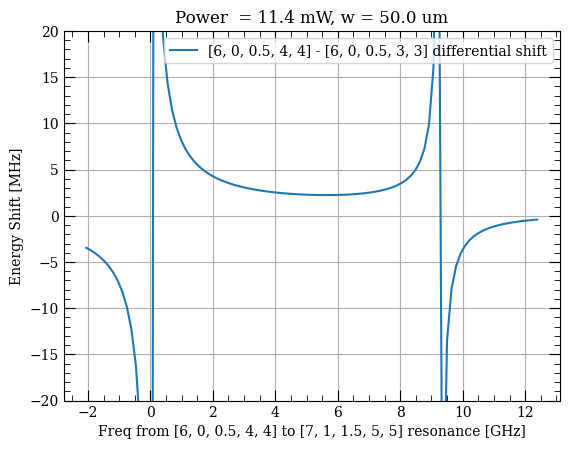

In [1045]:
target_state = [7,1,1.5,5,5]
deltas = [Delta(state1, target_state, wavelength)/(2*np.pi)*1e-9 for wavelength in wavelengths]

plt.plot(deltas, dUs, label = f"{state1} - {state2} differential shift")
# plt.plot(deltas, U1s, label = f"{state1} shift")
# plt.plot(deltas, U2s, label = f"{state2} shift")
plt.ylim(-20, 20)
plt.xlabel(f"Freq from {state1} to {target_state} resonance [GHz]")
plt.ylabel("Energy Shift [MHz]")
plt.title(f"Power  = {P*1e3} mW, w = {w*1e6} um")
plt.grid()
plt.legend()

In [1048]:
wavelengths = np.linspace(1066.65e-9, 1066.66e-9, 101)
# wavelengths = [C_c / ((657932.608 + 1)*1e9)]
P = 1
w = 50e-6
q = -1

state1 = [6,0,0.5,4,4]
state2 = [7,1,1.5,5,5]

dUs = []
U1s = []
U2s = []
for wavelength in wavelengths:
    U1 = ac_stark(state1, wavelength, P, w, q)
    U2 = ac_stark(state2, wavelength, P, w, q)
    U1s.append(U1 * 1e-6 / (2*np.pi))
    U2s.append(U2 * 1e-6 / (2*np.pi))
    dUs.append((U1-U2) * 1e-6 / (2*np.pi))
# print(U1s)

UnboundLocalError: cannot access local variable 'basis' where it is not associated with a value

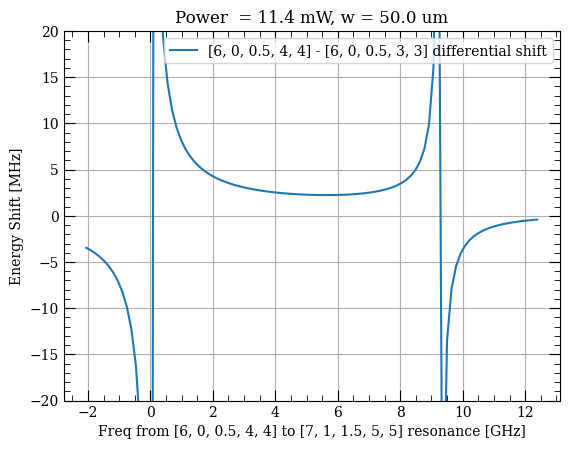

In [1047]:
target_state = [41,0,0.5,4,4]
deltas = [Delta(state1, target_state, wavelength)/(2*np.pi)*1e-9 for wavelength in wavelengths]

plt.plot(deltas, dUs, label = f"{state1} - {state2} differential shift")
# plt.plot(deltas, U1s, label = f"{state1} shift")
# plt.plot(deltas, U2s, label = f"{state2} shift")
plt.ylim(-20, 20)
plt.xlabel(f"Freq from {state1} to {target_state} resonance [GHz]")
plt.ylabel("Energy Shift [MHz]")
plt.title(f"Power  = {P*1e3} mW, w = {w*1e6} um")
plt.grid()
plt.legend()

### Backing out possible powers / waists given differential light shift measurement

In [776]:
freq = 657932.608*1e9
# wavelength = C_c / freq
wavelength = 455.655e-9

P = 0.01
w = 25e-6
q = 1

state1 = [6,0,0.5,4,4]
state2 = [6,0,0.5,3,3]

U2_test, contrib2 = ac_stark(state2, wavelength, P, w, q, largest_contrib = 1)
print(contrib2)
# print(U2_test)

#kinda hard...
guess_P_w = (P, w)

def extract_omega(dU, wavelength, guess_P_w):
    # dU should be in rad/s
    P, w = guess_P_w
    U1_test, contrib1 = ac_stark(state1, wavelength, P, w, q, largest_contrib = 1)
    U2_test, contrib2 = ac_stark(state2, wavelength, P, w, q, largest_contrib = 1)

    delta_1 = contrib1[-1][1]
    delta_2 = contrib2[-1][1]
    
    Omega_1 = contrib1[-1][2]
    Omega_2 = contrib2[-1][2]

    dU_test = U1_test - U2_test
    print(dU_test*1e-6/(2*np.pi))

    factor = np.sqrt(dU / dU_test)

    return factor, factor * Omega_1, factor * Omega_2

dU = 3e6*2*np.pi
factor, _, _, = extract_omega(dU, wavelength, guess_P_w)
print(factor)

[[[7, 1, 1.5, 4, 4], np.float64(-25809753744.206387), np.float64(1331162733.8079062), np.float64(-17163997.780070882)]]
7.942007179461138
0.6146041518043234


## Detuning and Rabi Frequency Testing

In [332]:
state_e = [7,0,1/2,4,4]
state_g = [6,1,3/2,5,5]

wavelength = C_c / (657932.608*1e9)
print(wavelength*1e9)

wavelength = 1064*1e-9

Delta(state_g, state_e, wavelength) * 1e-9 / (2*np.pi)

455.6583065723351


np.float64(77805.58868865094)

In [175]:
P_c= 100e-3
w_c = 25e-6
P_p = 1e-3
w_p = 25e-6

Delta = 3.3e9

state_r = [41,0,1/2,4,4]
state_e = [7,1,3/2,5,5]
state_g = [6,0,1/2,4,4]


OmC = Omega(state_e, state_r, P_c, w_c, -1) * 1e-6 / (2*np.pi)
OmP = Omega(state_g, state_e, P_p, w_p, 1) * 1e-6 / (2*np.pi)
OmR = OmC * OmP / (2*(Delta * 1e-6))

Pop_e_p = 0.5 * (OmP**2) / (2 * (Delta * 1e-6) ** 2)
Pop_e_c = 0.5 * (OmC**2) / (2 * (Delta * 1e-6) ** 2)
Gamma = 1.0 / cs.getStateLifetime(state_e[0], state_e[1], state_e[2])

print(OmP, OmC)
print(OmR)
print(Pop_e_p * Gamma * 1e-6, Pop_e_c * Gamma * 1e-6)

103.79033254715002 -83.97551587411672
-1.320582836120159
0.001905609071116621 0.0012474563713434266


In [673]:
P = 30e-3
w = 3.4e-6
state2 = [61,2,1.5,3,3]
state1 = [61,1,0.5,2,2]

Omega(state1, state2, P, w, 1) * 1e-9 / (2*np.pi)

np.float64(424.5321825597565)

In [380]:
P = 1
w = 25e-6
state1 = [6,1,3/2,5,5]

state2 = [7,0,1/2,4,4]
print(Omega(state1, state2, P, w, -1) * 1e-6 / (2*np.pi))

state2 = [6,2,5/2,6,6]
print(Omega(state1, state2, P, w, 1) * 1e-6 / (2*np.pi))

36313.14094706942
28052.442469757138


In [975]:
P = 1e-3
w = 25e-6
state2 = [7,1,3/2,5,5]
state1 = [6,0,1/2,4,4]

Omega(state1, state2, P, w, 1) * 1e-6 / (2*np.pi)

np.float64(103.79033254715002)

In [455]:
P = 1
w = 25e-6
q = -1
state2 = [41,0,1/2,-1/2]
state1 = [7,1,3/2,5,5]
omega = Omega(state1, state2, P, w, q) * 1e-6 / (2*np.pi)
print(omega)

Omega_squared = 0
for i in range(-5, 6, 1):
    state1 = [7,1,3/2,5,i]
    Omega_squared += (Omega(state1, state2, P, w, q) * 1e-6 / (2*np.pi))**2

for i in range(-4, 5, 1):
    state1 = [7,1,3/2,4,i]
    Omega_squared += (Omega(state1, state2, P, w, q) * 1e-6 / (2*np.pi))**2

for i in range(-3, 4, 1):
    state1 = [7,1,3/2,3,i]
    Omega_squared += (Omega(state1, state2, P, w, q) * 1e-6 / (2*np.pi))**2

for i in range(-2, 3, 1):
    state1 = [7,1,3/2,2,i]
    Omega_squared += (Omega(state1, state2, P, w, q) * 1e-6 / (2*np.pi))**2

print(np.sqrt(Omega_squared))

-0.0
433.64769929284085
